In [0]:
import torch
import torchvision
import numpy as np 
from torchvision import transforms, datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from skimage import io
import re
import warnings
import os
from torch.utils.data.sampler import SubsetRandomSampler
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/Capstone/img_patches_64_c8.zip /content

In [0]:
!unzip /content/img_patches_64_c8.zip

In [0]:
# clean some files if needed 
 from shutil import rmtree
 rmtree('/content/img_patches_64_c8/serial')
 rmtree('/content/img_patches_64_c8/streak')
# rmtree('/content/Img_Patches/Streak')
# rmtree('/content/Img_Patches/Control')
# #os.remove('/content/masked_images2.zip') 
# #rmtree() 

In [0]:
data_dir='/content/img_patches_64_c8'
train_dir = data_dir + '/serial-train'
valid_dir = data_dir + '/serial-val'
test_dir = data_dir + '/control'
print("Serial: training data:\n")
result=[]
for c in sorted(os.listdir(train_dir)):
  total=train_dir+'/'+c
  result.append(len(os.listdir(total)))

train_list=result
train_ratio_list=[]
print("total is {}\n".format(sum(result)))
for c, total in zip(sorted(os.listdir(train_dir)),result):
  train_ratio_list.append(total*1.0/sum(result))
  print("{} : {}     ratio:{}".format(c,total,total*1.0/sum(result)))


print("Serial: validation data:\n")
result=[]
for c in sorted(os.listdir(valid_dir)):
  total=valid_dir+'/'+c
  result.append(len(os.listdir(total)))

valid_list=result
valid_ratio_list=[]
print("total is {}\n".format(sum(result)))
for c, total in zip(sorted(os.listdir(valid_dir)),result):
  valid_ratio_list.append(total*1.0/sum(result))
  print("{} : {}     ratio:{}".format(c,total,total*1.0/sum(result)))

print("Control: test data:\n")
result=[]
l_t=os.listdir(test_dir)
l_t.remove('.DS_Store')
for c in sorted(l_t):
  total=test_dir+'/'+c
  result.append(len(os.listdir(total)))
test_list=result
test_ratio_list=[]
print("total is {}\n".format(sum(result)))  
for c, total in zip(sorted(l_t),result):
  test_ratio_list.append(total*1.0/sum(result))
  print("{} : {}     ratio:{}".format(c,total,total*1.0/sum(result)))


Serial: training data:

total is 16395

1 : 909     ratio:0.05544373284537969
2 : 1636     ratio:0.09978652028057335
3 : 4900     ratio:0.29887160719731626
4 : 2400     ratio:0.1463860933211345
5 : 1003     ratio:0.06117718816712412
6 : 1409     ratio:0.08594083562061604
7 : 352     ratio:0.02146996035376639
8 : 3786     ratio:0.23092406221408965
Serial: validation data:

total is 4103

1 : 228     ratio:0.055569095783573
2 : 409     ratio:0.09968315866439191
3 : 1226     ratio:0.2988057518888618
4 : 601     ratio:0.1464781866926639
5 : 251     ratio:0.06117475018279308
6 : 353     ratio:0.08603460882281258
7 : 88     ratio:0.021447721179624665
8 : 947     ratio:0.23080672678527905
Control: test data:

total is 3655

1 : 155     ratio:0.04240766073871409
2 : 261     ratio:0.07140902872777018
3 : 963     ratio:0.2634746922024624
4 : 471     ratio:0.12886456908344734
5 : 141     ratio:0.038577291381668946
6 : 205     ratio:0.0560875512995896
7 : 83     ratio:0.02270861833105335
8 : 1376 

In [0]:
temp_ratio=1/np.array(train_list)
train_weight=temp_ratio/sum(temp_ratio)
train_weight=torch.FloatTensor(train_weight)

temp_ratio=1/np.array(valid_list)
validate_weight=temp_ratio/sum(temp_ratio)
validate_weight=torch.FloatTensor(validate_weight)

temp_ratio=1/np.array(test_list)
test_weight=temp_ratio/sum(temp_ratio)
test_weight=torch.FloatTensor(test_weight)

In [0]:
training_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                          #transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5], 
                                                               [0.5, 0.5, 0.5])])

validation_transforms = transforms.Compose([#transforms.Resize(256),
                                            #transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5, 0.5, 0.5], 
                                                                 [0.5, 0.5, 0.5])])

testing_transforms = transforms.Compose([#transforms.Resize(256),
                                         #transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5, 0.5, 0.5], 
                                                              [0.5, 0.5, 0.5])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# # TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=256,shuffle=True)

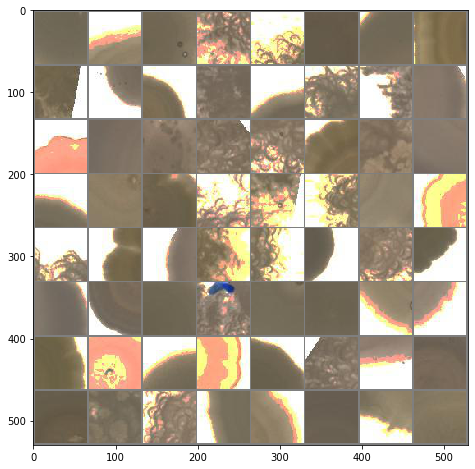

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        #self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(115200, 120)
        self.fc3 = nn.Linear(120, 8)
        
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.conv1(x)) 
        #x = F.relu(self.conv2(x))
        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
net = Net()

In [0]:
train_losses = []
train_counter = []
valid_losses = []
valid_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()

  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, 
            batch_idx * len(data), 
            len(train_loader.dataset),
            100. * batch_idx / len(train_loader), 
            loss.item()))
      
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')


def valid():
  network.eval()
  valid_loss = 0
  correct = 0

  with torch.no_grad():
    
    for data, target in valid_loader:
      
      output = network(data)
      valid_loss += criterion(output, 
                             target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()

  # valid_loss /= len(valid_loader.dataset)
  valid_losses.append(valid_loss)

  print('\Vaild set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, 
        correct, 
        len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=train_weight)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
training_loss=[]
validation_acc=[]
for epoch in range(10):  # loop over the dataset multiple times
    print("epoch {} \n".format(epoch))
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 50 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            training_loss.append(running_loss)
            class_correct = list(0. for i in range(8))
            class_total = list(0. for i in range(8))
            true_label= torch.tensor([-1])
            prediction=torch.tensor([-1])
            for data in validate_loader:
                images, labels = data
                true_label=torch.cat((true_label,labels))
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                prediction=torch.cat((prediction,predicted))
                c = (predicted == labels).squeeze()
                for i in range(len(c)):
                  label = labels[i]
                  class_correct[label] += c[i].item()
                  class_total[label] += 1 
            print('Accuracy of the network on the validation images: {}'.format(sum((np.array(class_correct)/np.array(class_total))*np.array(validate_weight))))
            running_loss = 0.0
print('Finished Training')

epoch 0 

[1,   100] training loss: 1.045
Accuracy of the network on the validation images: 0.6542776367495244
[1,   200] training loss: 1.036
Accuracy of the network on the validation images: 0.7061356278177143
epoch 1 

[2,   100] training loss: 1.001
Accuracy of the network on the validation images: 0.6692440665779654
[2,   200] training loss: 0.987
Accuracy of the network on the validation images: 0.7135530134790662
epoch 2 

[3,   100] training loss: 0.949
Accuracy of the network on the validation images: 0.6302427614988797
[3,   200] training loss: 0.931
Accuracy of the network on the validation images: 0.6546411772195297
epoch 3 

[4,   100] training loss: 0.898
Accuracy of the network on the validation images: 0.7291441817535835
[4,   200] training loss: 0.894
Accuracy of the network on the validation images: 0.6541742491901388
epoch 4 

[5,   100] training loss: 0.855
Accuracy of the network on the validation images: 0.6940601911838695
[5,   200] training loss: 0.890
Accuracy 

In [0]:
PATH = './shallow_net_bacteria64_serial.pth'
torch.save(net.state_dict(), PATH)

In [0]:
!cp ./shallow_net_bacteria64_serial.pth /content/drive/My\ Drive/Capstone/

In [0]:
prediction=[]
truth=[]
for data in validate_loader:
    images, labels = data
    true_label=torch.cat((true_label,labels))
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    prediction.extend(predicted.tolist())
    truth.extend(labels.tolist())

In [0]:
from pandas import DataFrame as df
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,prediction)

In [0]:
t=np.array(range(len(validation_dataset)))*(np.array(truth)==2)*(np.array(prediction)==3)
index_2_3=t[t!=0][:150]
#validation_dataset[index_2_3]

# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # show images
# imshow(torchvision.utils.make_grid(images))

In [0]:
# validation result
vals = [i+1 for i in range(8)]
df2 = df(cm, vals, vals)
df2

,1,2,3,4,5,6,7,8
1,91,54,0,0,65,17,0,1
2,56,262,8,0,38,38,0,7
3,0,19,574,600,7,5,0,21
4,0,4,166,420,3,0,0,8
5,8,25,15,4,122,76,0,1
6,3,15,1,0,49,285,0,0
7,0,0,0,0,0,0,87,1
8,0,18,26,42,11,0,0,850


In [0]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
true_label= torch.tensor([-1])
prediction=torch.tensor([-1])
for data in validate_loader:
    images, labels = data
    true_label=torch.cat((true_label,labels))
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    prediction=torch.cat((prediction,predicted))
    c = (predicted == labels).squeeze()
    for i in range(len(c)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 
print('Accuracy of the network on the validation images: {}'.format(sum((np.array(class_correct)/np.array(class_total))*np.array(validate_weight))))

Accuracy of the network on the validation images: 0.7449942721155807


## Performance on test dataset 

In [0]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
true_label= torch.tensor([-1])
prediction=torch.tensor([-1])
for data in test_loader:
    images, labels = data
    true_label=torch.cat((true_label,labels))
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    prediction=torch.cat((prediction,predicted))
    c = (predicted == labels).squeeze()
    for i in range(len(c)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1 

In [0]:
print('Accuracy of the network on the test images: {}'.format(sum((np.array(class_correct)/np.array(class_total))*np.array(test_weight))))

Accuracy of the network on the test images: 0.46651263235578927
